# Analyze differences in GFP intensity between WT and VAR

Author: Jess Ewald

Here we compute differences in GFP mean instensity between WT and VAR within the same plate, after filtering to remove cells with weird nucleus:cell area ratios. 

In [1]:
import polars as pl
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf
from tqdm import tqdm

In [37]:
b7_prof = "/dgx1nas1/storage/data/sam/codes/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_01_23_Batch_7"
b8_prof = "/dgx1nas1/storage/data/sam/codes/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_02_06_Batch_8"
class_res = "/dgx1nas1/storage/data/jess/varchamp/sc_data/classification_results/B7B8_1percent"

In [17]:
# calculate the median GFP MeanIntensity of cells/nuclei/cytoplasm in each well

select_cols = ['Metadata_well_position', 'Metadata_plate_map_name', 'Metadata_ImageNumber', 'Metadata_gene_allele', 'Metadata_Plate', 
               'Nuclei_AreaShape_Area', 'Cells_AreaShape_Area', 'Cytoplasm_Intensity_MeanIntensity_GFP', 'Cells_Intensity_MeanIntensity_GFP', 'Nuclei_Intensity_MeanIntensity_GFP']


b7 = pl.scan_parquet(f"{b7_prof}/profiles.parquet").select(select_cols).with_columns(
    (pl.col("Nuclei_AreaShape_Area")/pl.col("Cells_AreaShape_Area")).alias("Nucleus_Cell_Area")
    ).filter((pl.col("Nucleus_Cell_Area") > 0.1) & (pl.col("Nucleus_Cell_Area") < 0.4)).group_by(
        ['Metadata_Plate', 'Metadata_well_position', 'Metadata_gene_allele']
        ).agg([
            pl.col("Cytoplasm_Intensity_MeanIntensity_GFP").median().alias("Cytoplasm_Intensity_MeanIntensity_GFP"),
            pl.col("Cells_Intensity_MeanIntensity_GFP").median().alias("Cells_Intensity_MeanIntensity_GFP"),
            pl.col("Nuclei_Intensity_MeanIntensity_GFP").median().alias("Nuclei_Intensity_MeanIntensity_GFP"),
            pl.len().alias("Cell_count"),
            pl.lit("batch7").alias("Batch")
        ]).collect() 

b8 = pl.scan_parquet(f"{b8_prof}/profiles.parquet").select(select_cols).with_columns(
    (pl.col("Nuclei_AreaShape_Area")/pl.col("Cells_AreaShape_Area")).alias("Nucleus_Cell_Area")
    ).filter((pl.col("Nucleus_Cell_Area") > 0.1) & (pl.col("Nucleus_Cell_Area") < 0.4)).group_by(
        ['Metadata_Plate', 'Metadata_well_position', 'Metadata_gene_allele']
        ).agg([
            pl.col("Cytoplasm_Intensity_MeanIntensity_GFP").median().alias("Cytoplasm_Intensity_MeanIntensity_GFP"),
            pl.col("Cells_Intensity_MeanIntensity_GFP").median().alias("Cells_Intensity_MeanIntensity_GFP"),
            pl.col("Nuclei_Intensity_MeanIntensity_GFP").median().alias("Nuclei_Intensity_MeanIntensity_GFP"),
            pl.len().alias("Cell_count"),
            pl.lit("batch8").alias("Batch")
        ]).collect() 
        
cell_int = pl.concat([b7, b8])

# Add extra annotations
cell_int = cell_int.with_columns(
    pl.col("Metadata_Plate").str.replace("_.*", "").alias("Platemap"),
    pl.col("Metadata_gene_allele").str.replace("_.*", "").alias("Gene_symbol"),
    pl.when(pl.col("Metadata_gene_allele").str.contains("_")).then(pl.lit("VAR")).otherwise(pl.lit("WT")).alias("Type")
)


In [41]:
metrics = pl.read_csv(f"{class_res}/metrics_summary.csv").filter(pl.col("AUROC_mean").is_not_null())
variants = metrics.select("allele_0").to_series().unique().to_list()

In [42]:
def lmm(fix_var: str, rand_var: str, var: str, gene: str, dat):
    # perform stat test
    model = smf.mixedlm(f"{fix_var} ~ Type", data=dat, groups=dat[rand_var])
    result = model.fit()
    
    # format results
    summary_df = pl.DataFrame(result.summary().tables[1][1:2])
    summary_df = summary_df.with_columns(
        [pl.col(column).cast(pl.Float64).alias(column) for column in summary_df.columns]
    )
    summary_df = summary_df.with_columns(
        pl.lit(var).alias("Variant"),
        pl.lit(gene).alias("Gene")
    )
    
    return(summary_df)

In [ ]:
# Analyze to detect differences in intensity of diff compartments between WT and VAR
# Takes ~2.5 minutes
cell_res = []
nuc_res = []
cyto_res = []
for variant in tqdm(variants):
    # get data for variant
    gene_symb = variant.split("_")[0]
    
    # ensure that only wt-var pairs on same plate are included
    var_int = cell_int.filter(pl.col("Metadata_gene_allele") == variant)
    var_plates = var_int.select("Metadata_Plate").to_series().unique().to_list()
    wt_int = cell_int.filter((pl.col("Metadata_gene_allele") == gene_symb) &
                          (pl.col("Metadata_Plate").is_in(var_plates)))
    wt_plates = wt_int.select("Metadata_Plate").to_series().unique().to_list()
    var_int = var_int.filter(pl.col("Metadata_Plate").is_in(wt_plates))
    
    var_int = pl.concat([var_int, wt_int]).to_pandas()
    
    try:
        # append results
        cyto_res.append(lmm("Cytoplasm_Intensity_MeanIntensity_GFP", "Metadata_Plate", variant, gene_symb, var_int))
        cell_res.append(lmm("Cells_Intensity_MeanIntensity_GFP", "Metadata_Plate", variant, gene_symb, var_int))
        nuc_res.append(lmm("Nuclei_Intensity_MeanIntensity_GFP", "Metadata_Plate", variant, gene_symb, var_int))
        
    except Exception as e:
        print(f"An error occurred with variant {variant}: {str(e)}")

cyto_res = pl.concat(cyto_res)
cell_res = pl.concat(cell_res)
nuc_res = pl.concat(nuc_res)

In [46]:
cell_res.sort(pl.col("z"), descending=True)

Coef.,Std.Err.,z,P>|z|,[0.025,0.975],Variant,Gene
f64,f64,f64,f64,f64,f64,str,str
0.008,0.001,15.742,0.0,0.007,0.009,"""DES_Ala337Pro""","""DES"""
0.013,0.001,15.048,0.0,0.011,0.014,"""PNPO_Arg95His""","""PNPO"""
0.002,0.0,13.894,0.0,0.002,0.003,"""KRT2_Glu476Val…","""KRT2"""
0.012,0.001,13.587,0.0,0.01,0.014,"""PNPO_Arg116Gln…","""PNPO"""
0.013,0.001,13.346,0.0,0.011,0.015,"""RP2_Leu253Arg""","""RP2"""
0.013,0.001,13.247,0.0,0.011,0.015,"""RP2_Cys86Tyr""","""RP2"""
0.002,0.0,12.496,0.0,0.001,0.002,"""POMT1_Trp560Cy…","""POMT1"""
0.001,0.0,11.969,0.0,0.001,0.002,"""RASA1_Tyr426Cy…","""RASA1"""
0.008,0.001,11.537,0.0,0.007,0.009,"""DES_Tyr331Asn""","""DES"""


In [47]:
print(cell_res.shape)
print(cell_res.filter(pl.col("z") > 0).shape)
print(cell_res.filter(pl.col("z") < 0).shape)

print(nuc_res.shape)
print(nuc_res.filter(pl.col("z") > 0).shape)
print(nuc_res.filter(pl.col("z") < 0).shape)

print(cyto_res.shape)
print(cyto_res.filter(pl.col("z") > 0).shape)
print(cyto_res.filter(pl.col("z") < 0).shape)

(792, 8)
(417, 8)
(375, 8)
(792, 8)
(405, 8)
(387, 8)
(793, 8)
(424, 8)
(369, 8)


/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 623'. Pick better value with 'binwidth'.


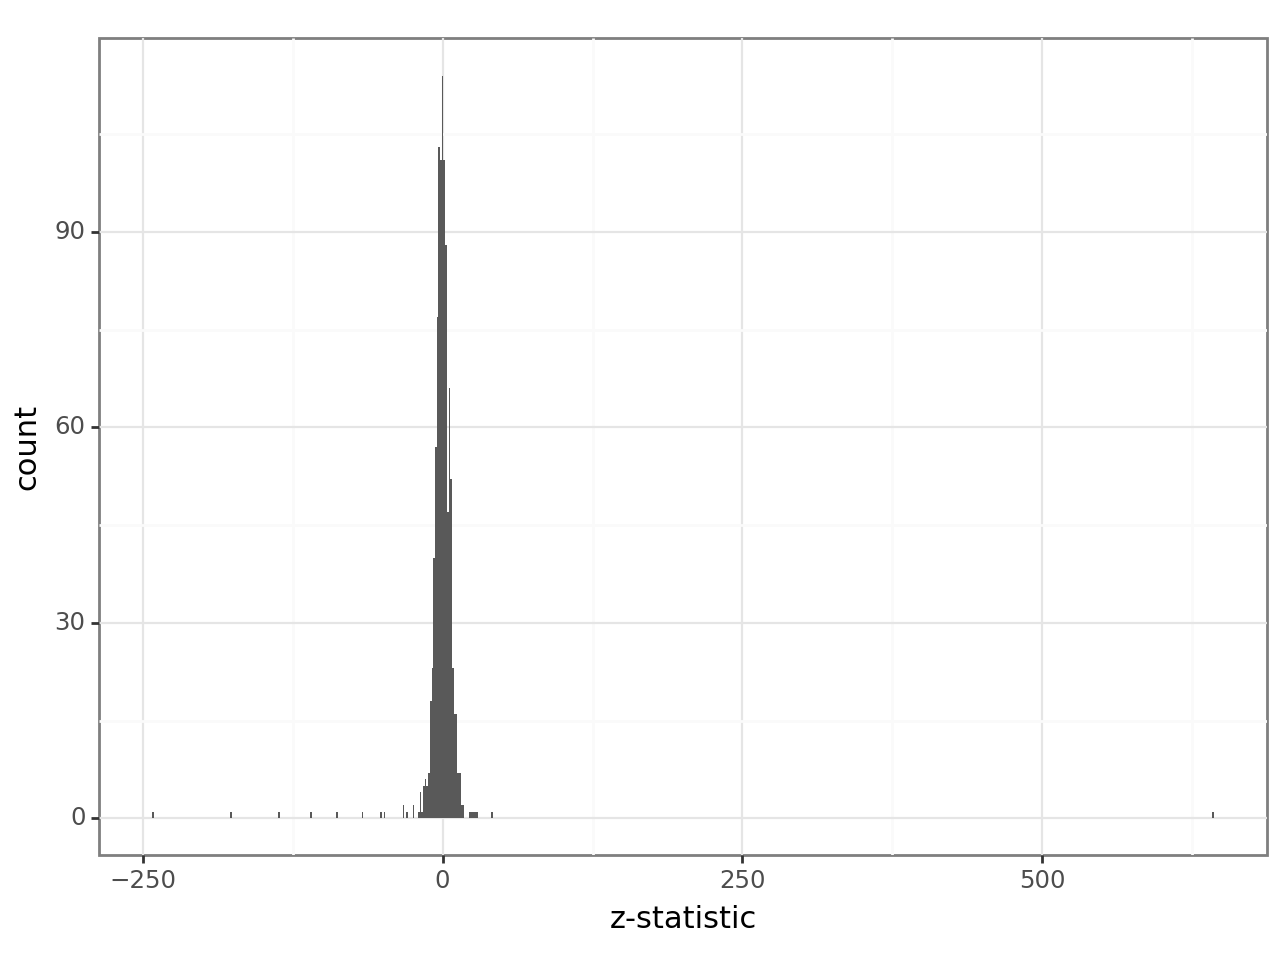

In [32]:
from plotnine import ggplot, aes, geom_histogram, theme_bw, xlab

plot1 = (ggplot(nuc_res) 
+ aes(x = "z")
+ geom_histogram()
+ theme_bw()
+ xlab("z-statistic"))

print(plot1)